In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import erf
import seaborn as sns

from actxtimescale.bayes_integration import *
from actxtimescale.constants import DATAFRAMES_FOLDER, USED_FILES
from actxtimescale.funs import bias_variance
from actxtimescale.plot import myerrorbar, plot_posteriors, set_labels

%load_ext autoreload
%autoreload 2

In [2]:
tick_labelsize = 16
view = {'figure.figsize': (5, 5),  'axes.titlesize': 18, 'axes.labelsize': 18, 'lines.linewidth': 2, 'lines.markersize': 6,
         'xtick.labelsize': tick_labelsize, 'xtick.major.size': 2.5, 'xtick.major.pad': 2, 
         'ytick.labelsize': tick_labelsize, 'ytick.major.size': 2.5, 'ytick.major.pad': 2,
         'errorbar.capsize': 5, 'axes.labelpad': 0,
         'legend.fontsize': 14, 'axes.spines.top': False, 'axes.spines.right': False,
         'boxplot.flierprops.markersize': 2}

for key, val in view.items():
    mpl.rcParams[key] = val
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
t0bin, tfbin, dtbin, biased = 100, 1640, 20, 0
tf_autocorr = 760

fit_offset, shared_hem_tau = False, False

In [4]:
df_tau = pd.read_json(DATAFRAMES_FOLDER + 'df_tau_bias_variance_final.json')

In [5]:
df = df_tau.loc[(df_tau.t0bin == t0bin) & (df_tau.tfbin == tfbin) & (df_tau.dtbin == dtbin) & (df_tau.biased == biased) & \
                (df_tau.tf_autocorr == tf_autocorr) & (df_tau.fit_offset == fit_offset) & (df_tau.shared_hem_tau == shared_hem_tau)].copy()

df = df.sort_values(['hemisphere', 'logtau_corrected'], ascending=True)

df = df[df.index.isin(USED_FILES)]

print(df.hemisphere.value_counts())

print('FINAL NUMBER OF NEURONS IS ', len(df))

df['sd_logtau'] = np.sqrt(df['var_logtau'])
df['mean_fr'] = df['mean_spikes'] / (df['tfbin'] - df['t0bin']) * 1000
df['sd_fr'] = df['sd_spikes'] / (df['tfbin'] - df['t0bin']) * 1000
df['se_fr'] = df['sd_fr'] / np.sqrt(df['n_trials'])

df['log10tau_corrected'] = df['logtau_corrected'] / np.log(10)
df['sd_log10tau'] = df['sd_logtau'] / np.log(10)

right ACx    23
left ACx     22
Name: hemisphere, dtype: int64
FINAL NUMBER OF NEURONS IS  45


In [6]:
sorted(df.index.tolist())

['ACx_data_1/ACxCalyx/20080930-002',
 'ACx_data_1/ACxCalyx/20081104-002',
 'ACx_data_1/ACxCalyx/20100428-001',
 'ACx_data_1/ACxCalyx/20170903-001-017',
 'ACx_data_1/ACxCalyx/20170903-001-019',
 'ACx_data_1/ACxCalyx/20170909-007_file001',
 'ACx_data_1/ACxCalyx/20170909-010',
 'ACx_data_1/ACxCalyx/20190904-001-016',
 'ACx_data_1/ACxCalyx/20191010-005',
 'ACx_data_1/ACxCalyx/20200107-009-003',
 'ACx_data_1/ACxCalyx/20200108-008-002',
 'ACx_data_1/ACxThelo/20171114-d003-f004',
 'ACx_data_1/ACxThelo/20171204-f010',
 'ACx_data_1/ACxThelo/20171205-f002',
 'ACx_data_1/ACxThelo/20171205-f007',
 'ACx_data_1/ACxThelo/20171208-f015',
 'ACx_data_1/ACxThelo/20171208-f016',
 'ACx_data_1/ACxThelo/20180219-f014',
 'ACx_data_1/ACxThelo/20180219-f017',
 'ACx_data_1/ACxThelo/20180309-f005',
 'ACx_data_1/ACxThelo/20180322-f006',
 'ACx_data_2/ACxCalyx/20190918-xxx999-001-004',
 'ACx_data_2/ACxThelo/20171120-f003',
 'ACx_data_2/ACxThelo/20171208-f011',
 'ACx_data_2/ACxThelo/20171208-f018',
 'ACx_data_2/ACxTh

### fr vs tau

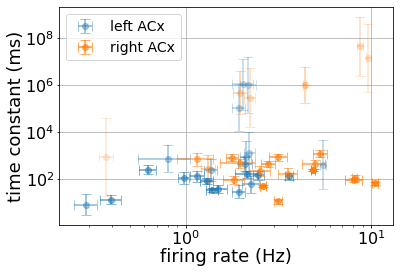

In [7]:
from matplotlib.ticker import FixedLocator

fig, ax1 = plt.subplots()

df['alpha'] = 1 - ((df['sd_log10tau'] - df['sd_log10tau'].min()) / (df['sd_log10tau'].max() - df['sd_log10tau'].min()))**0.2 + 0.15
df.loc[df['alpha'] > 1, 'alpha'] = 1
myerrorbar(x='mean_fr', y='log10tau_corrected', hue='hemisphere', xerr='se_fr', yerr='sd_log10tau', alpha='alpha', 
                                         data=df, ax=ax1, fmt='o')

# ax1.set_xlim(0, 11)
ax1.set_xscale('log')
ax1.grid(True, which='major')

ax1.set_yticks(ax1.get_yticks()[1:-1])

ax1.set_yticklabels([r"$10^{}$".format(str(int(yl))) for yl in ax1.get_yticks()])

set_labels(ax1, xlabel='firing rate (Hz)', ylabel='time constant (ms)')
sns.despine(top=False, right=False)

In [8]:
df.groupby('hemisphere')['tau_est'].mean(), df.groupby('hemisphere')['tau_est'].std()

(hemisphere
 left ACx     16657.250955
 right ACx    68875.207362
 Name: tau_est, dtype: float64,
 hemisphere
 left ACx      45818.176778
 right ACx    183313.564656
 Name: tau_est, dtype: float64)

## posterior distributions

quantiles [0.025, 0.975] [66.02279096 99.48431564]
mean, sd 82.46512294852094 8.81423598135611
quantiles [0.025, 0.975] [113.29556235 138.37951234]
mean, sd 126.32788711938562 6.670816399575955
log_marginal_likelihood, bayes factor, log10 bayrs factor -132.5541402076025 0.0020193882948421854 -2.6947801654082753


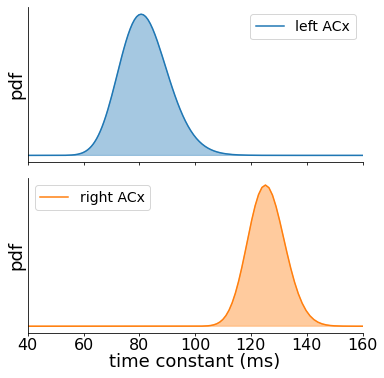

In [9]:
log, xlim = False, (0, 300)
# log, xlim = True, (0, 10)

fig, axs = plt.subplots(figsize=(6, 6), nrows=2, ncols=1, sharex=True, sharey=False)
fig.subplots_adjust(hspace=0.1)
lw = 0.4

logtau = np.arange(-5, 30, 1e-2)
tau = np.exp(logtau)

gaussian_mean = False
        
# plot_posteriors(axs, df, logtau, gaussian_mean=False, log=log, xlim=xlim, observations=True)
plot_posteriors(axs, df, logtau, gaussian_mean=gaussian_mean, log=False, xlim=(40, 160), observations=False)

for ax in axs:
    ax.set_ylabel('pdf')
    ax.set_yticks([])

xlabel = 'time constant (ms)' if not(log) else 'time constant (ms) (log)'
axs[1].set_xlabel(xlabel)

lml2 = log_marginal_likelihood(df, logtau, gaussian_mean=gaussian_mean)
lml1 = log_marginal_likelihood_single_model(df, logtau, gaussian_mean=gaussian_mean)
bayes_factor = 10**(lml1 - lml2)
log10_bf = (lml1 - lml2)

print('log_marginal_likelihood, bayes factor, log10 bayrs factor', lml2, bayes_factor, log10_bf)